## Overview of the Quantum Support Vector Machine Algorithm
The classical support vector machine is a powerful supervised machine learning tool used for binary classification. Researchers have decided to extend this popular algorithm in to the quantum world, hoping to see some near-term speeds for use to utilize.

### Quantum Classification
Generalized supervised learning works by trying to classify a set of points $\{\overrightarrow x\}$ into a group, $y$ (e.g. $y = \{-1,1\}$ in our case). What we want to do is find a line (or hyperplane for 3+ features) that seperates our data points into one of our classification groups. This line can be linear, but it can also be much more complex, in the classical SVM we achieve more complexity with the use of kernels. [1]

To do this on a quantum computer, we must encode our datapoints into quantum data points. i.e. map $X$ into $|\Phi({\overrightarrow x})\rangle $. We do this by using a quantum circuit: $V(\Phi({\overrightarrow x}))$ Where $\Phi(\overrightarrow x))$ could be any classical function applied on the classical data $\overrightarrow x$

Next, we must define a paramterized quantum circuit $W(\Theta)$ that processes data in a way such that when we measure our circuit, we obtain a classical value of 1 or -1, which will be the label of the quantum data.

With these steps we achieve the variational quantum circuit $W(\Theta)V(\Phi(\overrightarrow x))|0\rangle$


### Quantum SVM
With the previous steps in mind for the process of quantum classification, we can now create a quantum support vector machine.

#### Define A Quantum Kernel
A quantum feauture map is analougous to the classical feauture map. We take the inner product of our feauture map, $K(\overrightarrow x, \overrightarrow z) = |\langle\Phi(\overrightarrow x)|\Phi(\overrightarrow z)\rangle|^2 $, but with our quantum feature map. The reason for doing so is that in the near-term, we could potentially create quantum feature maps that are intractible to compute on a classical computer, thus giving us a quantum advantage.

**1. Quantum Feature Maps**

To create our quantum feature maps, we use the ansatz/ variational circuit mentioned in the classification steps up above. $V(\Phi(\overrightarrow x)) = U(\Phi(\overrightarrow x)) \otimes H^n$ as described in [2], which simplifies a lot when we only consider up to Ising like interactions, which means we only let two qubits interact at a time. This leads to interactions ZZ and non interacting terms Z. [1]

e.g. If we write this ansatz for n=2 qubits with the classical data vector $\overrightarrow x = (x_1, x_2)$ the feature map takes the form: 

$ U(\Phi(\overrightarrow x)) = e^{i(x_1 Z_1 + x_2 Z_2 + (\pi -x_1)(\pi -x_2)Z_1Z_2) }$
    
We can also define a depth for these circuit. Generally, the deeper it is the more accuracte the results. However, in the NISQ era this won't always be the case as our quantum computers can't handle very deep circuits, so the challenge is to find a circuit deep and expressive enough to be effective, while shallow enough to be computed on today's hardware.

**2. Measuring the Quantum Kernel**

One we have encoded and run our quantum feature map, we need to extract the data properly from our quantum kernel again from the quantum circuit to feed it into the classical SVM algorithm. We do this by calculating the overlap between our computed states, $K(\overrightarrow x, \overrightarrow z) = |\langle\Phi(\overrightarrow x)|\Phi(\overrightarrow z)\rangle|^2 $


references: 

[1] https://medium.com/@patrick.huembeli/introduction-into-quantum-support-vector-machines-727f3ccfa2b4

[2] https://arxiv.org/pdf/1804.11326.pdf

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import scipy
from scipy.linalg import expm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
def iris(training_size, test_size, n, PLOT_DATA=True):
    class_labels = [r'Class 0', r'Class 1']
    
    # First the dataset must be imported.
    data_set = datasets.load_iris()
    
    # To find if the classifier is accurate, a common strategy is
    # to divide the dataset into a training set and a test set.
    # Here the data is divided into 70% training, 30% testing.
    X_train, X_test, Y_train, Y_test = train_test_split(data_set.data, data_set.target, test_size=0.3, random_state=109)
    
    # Now the dataset's features will be standardized
    # to fit a normal distribution.
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # To be able to use this data with the given
    # number of qubits, the data must be broken down from
    # 30 dimensions to `n` dimensions.
    # This is done with Principal Component Analysis (PCA),
    # which finds patterns while keeping variation.
    pca = PCA(n_components=n).fit(X_train)
    X_train = pca.transform(X_train)
    X_test = pca.transform(X_test)

    # The last step in the data processing is
    # to scale the data to be between -1 and 1
    samples = np.append(X_train, X_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    X_train = minmax_scale.transform(X_train)
    X_test = minmax_scale.transform(X_test)

    # Now some sample should be picked to train the model from
    training_input = {key: (X_train[Y_train == k, :])[:training_size] for k, key in enumerate(class_labels)}
    test_input = {key: (X_train[Y_train == k, :])[training_size:(
        training_size+test_size)] for k, key in enumerate(class_labels)}

    if PLOT_DATA:
        for k in range(0, 2):
            x_axis_data = X_train[Y_train == k, 0][:training_size]
            y_axis_data = X_train[Y_train == k, 1][:training_size]
            
            label = 'Class 0' if k is 1 else 'Class 1'
            plt.scatter(x_axis_data, y_axis_data, label=label)

        plt.title("Datset")
        plt.legend()
        plt.show()
        

    return X_train, training_input, test_input, class_labels

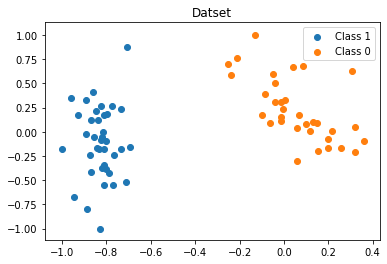

{'Class 0': 0, 'Class 1': 1}


In [6]:
from qiskit.aqua.utils import split_dataset_to_data_and_labels

n = 3 # How many features to use (dimensionality)
training_dataset_size = 40
testing_dataset_size = 10

sample_Total, training_input, test_input, class_labels = iris(training_dataset_size, testing_dataset_size, n)

datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

In [7]:
from qiskit.aqua.algorithms import QSVM
#from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.circuit.library import ZZFeatureMap

#feature_map = SecondOrderExpansion(feature_dimension=2, 
#                                   depth=1)

feature_map = ZZFeatureMap(3, reps=3)


x = np.array([0.6, 0.3])
#print(feature_map.construct_circuit(x))

qsvm = QSVM(feature_map, training_input, test_input)

In [8]:
from qiskit.aqua import QuantumInstance
from qiskit import BasicAer
import time

start = time.time()

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)

result = qsvm.run(quantum_instance)
end = time.time() - start
#print(result)
#print(result['yin'])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [ ]:
print('{:5f}'.format(end))

In [ ]:
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
labels = result['kernel_matrix_testing']

img = plt.imshow(np.asmatrix(kernel_matrix),interpolation='nearest',origin='upper',cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

In [ ]:
#print(datasets.load_wine())

In [10]:
print(datasets.load_iris())

{'data': array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
     